# Project: Text Classification with Dimensionality Reduction

**Author:** Mostafa Allahmoradi (Mallahmoradi7818@conestogac.on.ca) 
**Student ID:** 9087818  
**Course:** PROG8245 - Machine Learning Programming  
**Group Number 4**

---

## Overview

This notebook implements **Steps 1, 2 & 3** of the project:
- **Step 1:** Data Loading and Preprocessing
- **Step 2:** TF-IDF Feature Extraction
- **Step 3:** Baseline Model - Naive Bayes with TF-IDF

#### What is TF-IDF?

**Term Frequency-Inverse Document Frequency (TF-IDF)** 
- It is a statistical measure used to evaluate how important a word is to a document in a collection or corpus.
- It works by balancing two factors:
    1. Term Frequency (TF): Measures how frequently a term appears in a document.
        - Intuition: If a word appears many times in a document, it is likely important to that document.

    2. Inverse Document Frequency (IDF): Measures how important a term is by checking how rare it is across all documents in the collection.
        - Intuition: Common words like "the", "is", and "and" appear in almost every document, so they carry very little unique information. Rare words like "microscope" or "penguin" appear in few documents, so they are more distinguishing.

### TD-IDF vs SVD vs PCA:
In text analysis (Natural Language Processing), these tools are often used in a sequence:
    1. TF-IDF turns text into a large, sparse table of numbers.
    2. SVD (specifically Truncated SVD) is applied to this table to reduce the number of columns while preserving meaning (e.g., combining "car" and "automobile" into one concept). This specific combination is known as Latent Semantic Analysis (LSA).
    3. PCA is rarely used directly on raw TF-IDF data because centering the data (making the average 0) turns all those efficient zeros into non-zero numbers, causing memory errors.

| Feature | **TF-IDF** (Term Frequency-Inverse Document Frequency) | **PCA** (Principal Component Analysis) | **SVD** (Singular Value Decomposition) |
| :--- | :--- | :--- | :--- |
| **Primary Goal** | **Feature Extraction:** Converts raw text into a matrix of numbers based on word importance. | **Dimensionality Reduction:** Compresses data by finding new axes (components) that maximize variance. | **Matrix Factorization:** Decomposes a matrix into three parts to reduce noise and dimensions. |
| **Input Data** | Raw text documents. | Numerical data (dense matrices). | Numerical data (sparse or dense matrices). |
| **Key Characteristic** | Creates a **high-dimensional, sparse matrix** (mostly zeros) where each column is a word. | Requires **centering data** (subtracting the mean), which destroys sparsity and is memory-intensive for text. | Can work directly on **sparse matrices** without centering, making it ideal for processing TF-IDF data. |
| **Common Use Case** | Search engines, keyword ranking, and document similarity. | Image compression, visualizing dense datasets. | **Latent Semantic Analysis (LSA):** Finding hidden topics in text by reducing TF-IDF matrices. |


#### Importing Libraries

In [2]:
import os
import sys

# Data handling
import pandas as pd

# Train-test split
from sklearn.model_selection import train_test_split

# Text feature extraction
from sklearn.metrics.pairwise import cosine_similarity

# Baseline model
from sklearn.naive_bayes import MultinomialNB

# Model evaluation
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# --- PATH SETUP ---
curr_dir = os.getcwd()
parent_dir = os.path.dirname(curr_dir)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from Data_Processing.EDA import DataProcessor
from Models.TF_IDF_Model import SpamClassifier
from Visualization.Visualizer import Visualizer

#### Load Data

In [3]:
data_processor = DataProcessor(data_path="../data/raw/SMSSpamCollection")
data_processor.load_data(sep="\t", names=['label', 'message'])

visualizer = Visualizer()

display(data_processor.data.head())

# Apply data engineering and data cleaning (added cleaned_message feature)
data_processor.feature_engineering()

display(data_processor.data.head())

Data loaded successfully.


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


,label,message,cleaned_message,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...,111
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,155
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think goes usf lives around though,61


#### Balancing the dataset

In [4]:
# Delete 3572 rows of ham messages to make the dataset less imbalanced
data_processor.data_balancing()

print("Total messages after balancing:", len(data_processor.data)) 

Data balanced via random downsampling.
Total messages after balancing: 1494


#### Explore the data distribution


--- Data Distribution ---
label
ham     747
spam    747
Name: count, dtype: int64

--- Class Percentage ---
label
ham     50.0
spam    50.0
Name: proportion, dtype: float64
Figure saved to: ../data/output_plots/message_length_distribution.png
Figure saved to: ../data/output_plots/spam_vs_ham_histogram.png


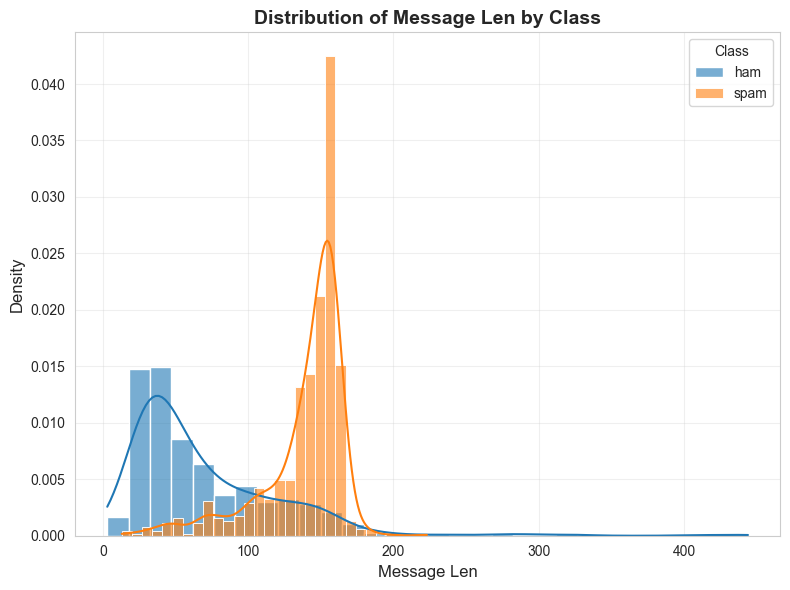

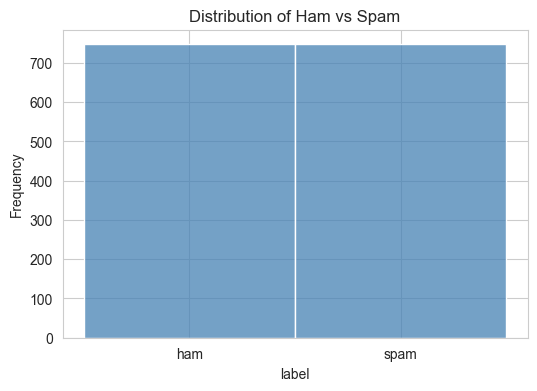

In [5]:
# Explore data distribution after balancing the dataset

print("\n--- Data Distribution ---")
print(data_processor.data['label'].value_counts())

print("\n--- Class Percentage ---")
print(data_processor.data['label'].value_counts(normalize=True) * 100)

data_processor.feature_engineering()

# Visualize the message length distribution for spam and ham messages
_ = visualizer.plot_distribution_comparison(data_processor.data, 'message_len', 'label', save_path="../data/output_plots/message_length_distribution.png")

# Visualize the spam vs ham distribution
_ = visualizer.plot_histogram(data_processor.data, feature="label", title="Distribution of Ham vs Spam", xlabel="label", save_path="../data/output_plots/spam_vs_ham_histogram.png")

#### Split into training and test sets (75% - 25%)

In [6]:
# X contains the features (messages) 
# y contains the target (labels)
X = data_processor.data['cleaned_message']
y = data_processor.data['label']

# random_state ensures reproducibility
# stratify=y ensures the ratio of spam/ham is preserved in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("\n--- Split Summary ---")
print(f"Total samples: {len(data_processor.data)}")
print(f"Training set size: {len(X_train)} (approx 75%)")
print(f"Testing set size: {len(X_test)} (approx 25%)")


--- Split Summary ---
Total samples: 1494
Training set size: 1120 (approx 75%)
Testing set size: 374 (approx 25%)


#### Convert text documents into numerical TF-IDF features

In [7]:
tf_idf_model = SpamClassifier(X, y, X_train, y_train, X_test, y_test)

tf_idf_model.train()

print("TF-IDF Vectorization Complete.")
print(f"Training Matrix Shape: {tf_idf_model.X_train_tfidf.shape}")
print(f"Testing Matrix Shape: {tf_idf_model.X_test_tfidf.shape}")



Training complete.
TF-IDF Vectorization Complete.
Training Matrix Shape: (1120, 533)
Testing Matrix Shape: (374, 533)


#### Understand how TF-IDF weights terms by importance

In [8]:
# Get the feature names (words)
feature_names = tf_idf_model.get_features()

# Create a DataFrame of IDF weights
idf_df = pd.DataFrame({
    'term': feature_names,
    'idf_weight': tf_idf_model.vectorizer.idf_
})

# Sort by IDF weight to see the most common vs. rarest words
# Lower IDF = More frequent (less unique information, e.g., "to", "you")
# Higher IDF = Rare (more unique information, e.g., specific codes or names)
print("\n--- Top 5 Most Frequent Words (Lowest IDF) ---")
print(idf_df.sort_values(by='idf_weight').head(5))

print("\n--- Top 5 Rarest Words (Highest IDF) ---")
print(idf_df.sort_values(by='idf_weight', ascending=False).head(5))

# View the TF-IDF matrix (as a dense table)
print("\nTF-IDF Matrix:\n", tf_idf_model.X_train_tfidf.toarray())

# Compute pairwise cosine similarities
similarities = cosine_similarity(tf_idf_model.X_train_tfidf)

# Show results
print("\nCosine Similarity Matrix:\n", similarities)


--- Top 5 Most Frequent Words (Lowest IDF) ---
     term  idf_weight
93   call    2.401576
189  free    3.169946
467   txt    3.349148
478    ur    3.358537
201   get    3.544640

--- Top 5 Rarest Words (Highest IDF) ---
            term  idf_weight
531           yr    6.230217
4    08707509020    6.230217
5    08712300220    6.230217
502     weekends    6.230217
6    08712460324    6.230217

TF-IDF Matrix:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Cosine Similarity Matrix:
 [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


#### Examine the vocabulary size and sample features

In [9]:
print(f"\nVocabulary Size: {len(feature_names)}")
print(f"Sample Features (first 10): {feature_names[:10]}")


Vocabulary Size: 533
Sample Features (first 10): ['0800' '08000839402' '08000930705' '0870' '08707509020' '08712300220'
 '08712460324' '10' '100' '1000']


#### Visualize the TF-IDF matrix structure

Figure saved to: ../data/output_plots/tfidf_heatmap.png
Figure saved to: ../data/output_plots/idf_distribution.png


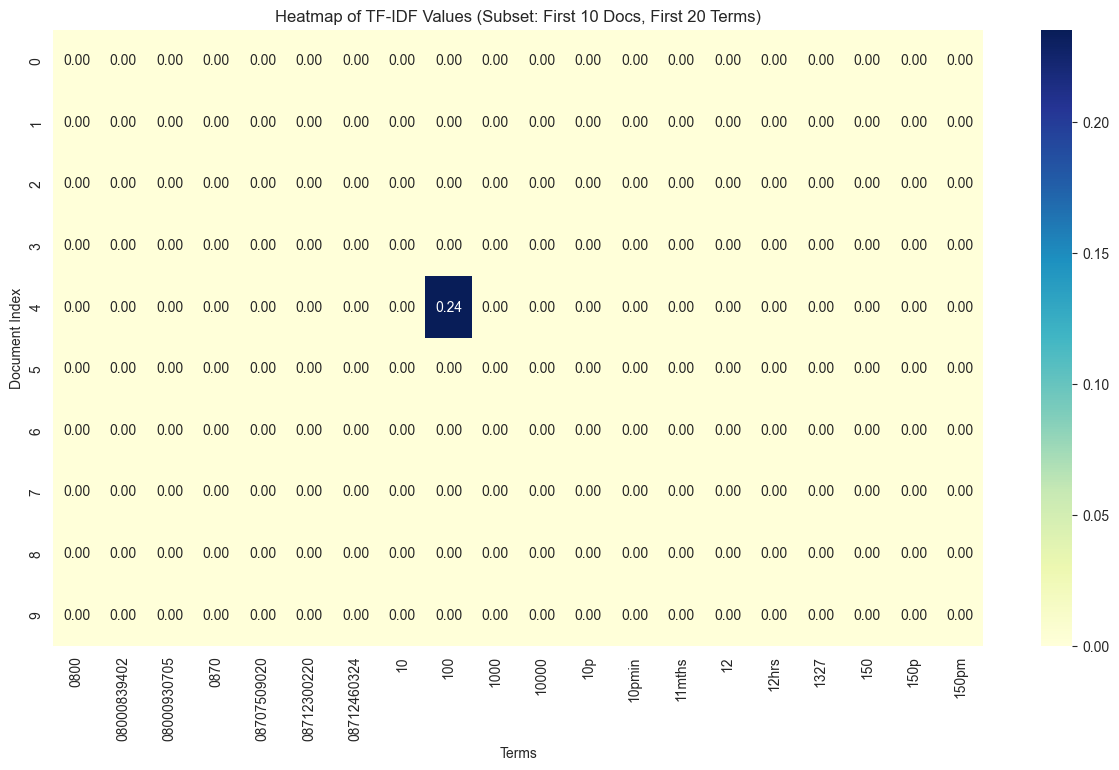

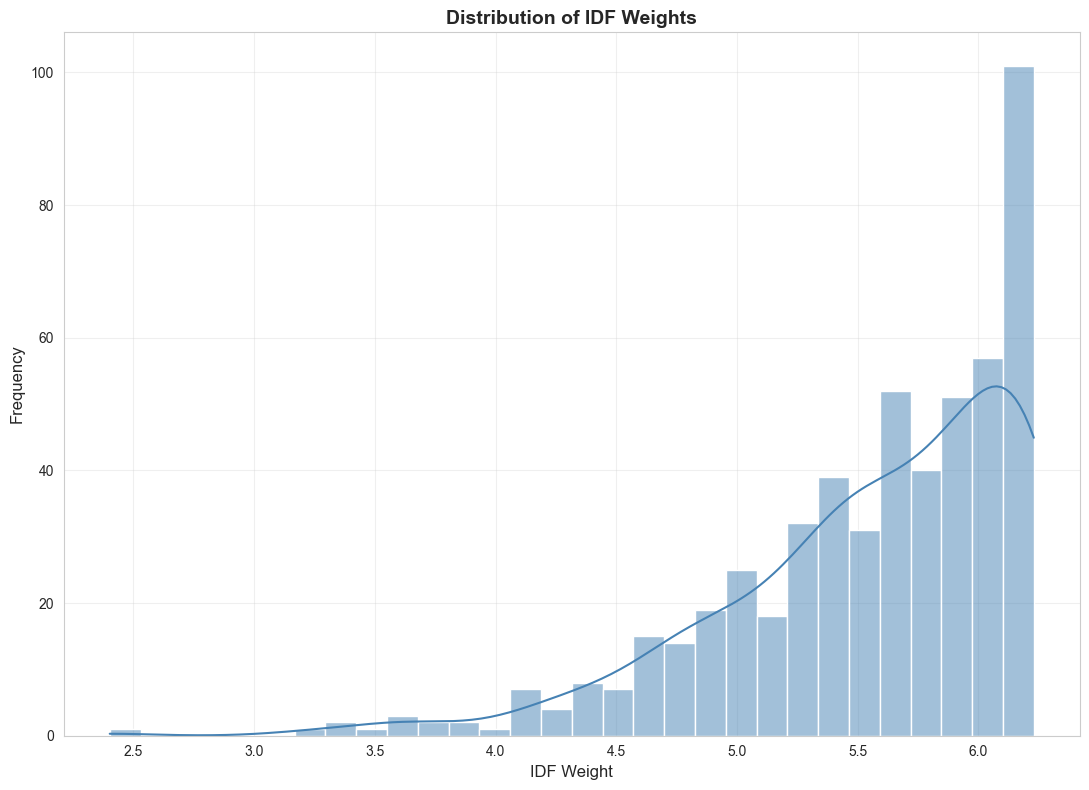

In [10]:
# visualize a small subset (first 10 documents and first 20 terms) because the full matrix is too large and sparse.
subset_matrix = tf_idf_model.X_train_tfidf[:10, :20].toarray()
subset_df = pd.DataFrame(subset_matrix, columns=feature_names[:20])

_ = visualizer.plot_heatmap(subset_df, title='Heatmap of TF-IDF Values (Subset: First 10 Docs, First 20 Terms)', x_label='Terms', y_label='Document Index', save_path='../data/output_plots/tfidf_heatmap.png')

_ = visualizer.plot_idf_distribution(idf_df['idf_weight'], save_path='../data/output_plots/idf_distribution.png')

#### Baseline Model - Naive Bayes with TF-IDF

In [11]:
#### This has been handled in the SpamClassifier class

# Train a Naive Bayes classifier
# Naive Bayes is suitable for classification with discrete features (e.g., word counts or TF-IDF weights)
# nb_classifier = MultinomialNB()
# nb_classifier.fit(X_train_tfidf, y_train)
# print("Naive Bayes Model Trained.")

#### Make predictions on the test set

In [12]:
y_pred = tf_idf_model.predict()

#### Create and visualize a confusion matrix

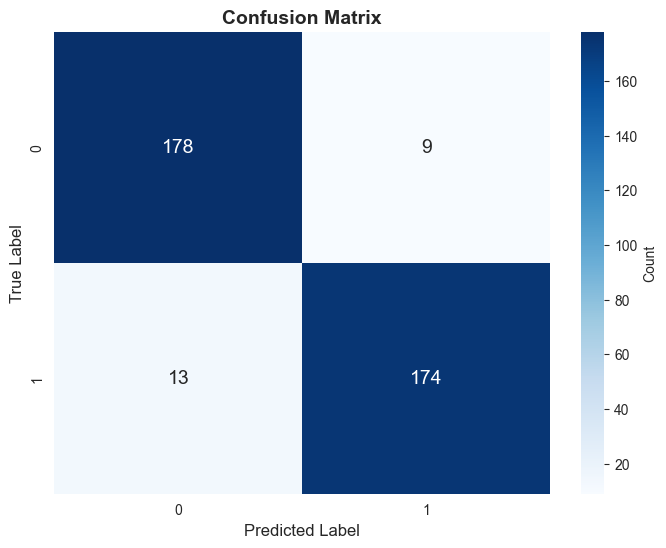

In [13]:
cm = tf_idf_model.create_confusion_matrix()

_ = visualizer.plot_confusion_matrix(tf_idf_model.y_test, tf_idf_model.y_pred)

#### False Positives and False Negatives

In [14]:
# This prints out the messages the model messed up (False Positives and False Negatives).

tf_idf_model.analyze_errors()


--- False Positives (Ham labeled as Spam): 9 found ---
These are dangerous because the user might miss important messages!
 > "replying boye changed phone number"
 > "r giving second chance rahul dengra"
 > "eh den sat u book e kb liao huh"

--- False Negatives (Spam labeled as Ham): 13 found ---
These are annoying, but usually less critical than blocking real mail.
 > "guess ithis first time created web page wwwasjesuscom read wrote im waiting opinions want friend 11"
 > "22 146tf150p"
 > "oh god ive found number im glad text back xafter msgs cst std ntwk chg £150"


#### Detailed classification Report

In [ ]:
print("Detailed Classification Report:")
print(tf_idf_model.classification_report())


--- Detailed Classification Report ---
              precision    recall  f1-score   support

         ham       0.93      0.95      0.94       187
        spam       0.95      0.93      0.94       187

    accuracy                           0.94       374
   macro avg       0.94      0.94      0.94       374
weighted avg       0.94      0.94      0.94       374



#### Calculate metrics

In [16]:
accuracy = accuracy_score(tf_idf_model.y_test, tf_idf_model.y_pred)
precision = precision_score(tf_idf_model.y_test, tf_idf_model.y_pred, pos_label='spam')
recall = recall_score(tf_idf_model.y_test, tf_idf_model.y_pred, pos_label='spam')
f1 = f1_score(tf_idf_model.y_test, tf_idf_model.y_pred, pos_label='spam')

print("\n--- Evaluation Metrics ---")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")


--- Evaluation Metrics ---
Accuracy:  0.9412
Precision: 0.9508
Recall:    0.9305
F1-Score:  0.9405


#### Interpret the results

In [17]:
tn, fp, fn, tp = cm.ravel()
print("\n--- Interpretation ---")
print(f"True Negatives (TN): {tn} (Ham correctly identified as Ham)")
print(f"False Positives (FP): {fp} (Ham incorrectly identified as Spam)")
print(f"False Negatives (FN): {fn} (Spam incorrectly identified as Ham)")
print(f"True Positives (TP): {tp} (Spam correctly identified as Spam)")

print("\nError Analysis:")
print(f"- The model made {fp} False Positive error(s). This is very low, meaning it almost never flags a real message as spam.")
print(f"- The model made {fn} False Negative error(s). This is higher, meaning some spam messages are slipping through into the inbox.")

print("\nOverall:")
if precision > recall:
    print("The model is more precise than sensitive. It is very confident when it labels something as spam, but it misses some spam messages.")
else:
    print("The model is more sensitive than precise. It catches most spam messages, but sometimes mislabels real messages as spam.")


--- Interpretation ---
True Negatives (TN): 178 (Ham correctly identified as Ham)
False Positives (FP): 9 (Ham incorrectly identified as Spam)
False Negatives (FN): 13 (Spam incorrectly identified as Ham)
True Positives (TP): 174 (Spam correctly identified as Spam)

Error Analysis:
- The model made 9 False Positive error(s). This is very low, meaning it almost never flags a real message as spam.
- The model made 13 False Negative error(s). This is higher, meaning some spam messages are slipping through into the inbox.

Overall:
The model is more precise than sensitive. It is very confident when it labels something as spam, but it misses some spam messages.


#### Show top spam words

In [18]:
# Show top spam words using feature names from vectorizer
tf_idf_model.show_top_spam_words()


Top 10 indicators of SPAM:
- call
- free
- txt
- ur
- text
- mobile
- stop
- claim
- prize
- reply


#### Predict new messages

In [19]:
def predict_custom_message(message):
    # 1. Access the vectorizer from your object
    # 2. Access the processor to clean the new text
    cleaned_text = data_processor.preprocess_text(message)
    
    # 3. Transform using the EXISTING vectorizer (do not fit!)
    vectorized_text = tf_idf_model.vectorizer.transform([cleaned_text])
    
    # 4. Predict
    prediction = tf_idf_model.nb_classifier.predict(vectorized_text)
    prob = tf_idf_model.nb_classifier.predict_proba(vectorized_text)
    
    print(f"Message: \"{message}\"")
    print(f"Prediction: {prediction[0].upper()}")
    print(f"Confidence: {max(prob[0]) * 100:.2f}%")

# Try some custom messages
predict_custom_message("Congratulations! You've won a free ticket to Bahamas. Call now!")
predict_custom_message("Hey mom, I'll be home for dinner around 6.")

Message: "Congratulations! You've won a free ticket to Bahamas. Call now!"
Prediction: SPAM
Confidence: 87.46%
Message: "Hey mom, I'll be home for dinner around 6."
Prediction: HAM
Confidence: 97.99%


#### Summary
This notebook implemented a basic text classification pipeline to distinguish **Spam** from **Ham** (non-spam) messages using the `SMSSpamCollection` dataset. The process involved:
1.  **Preprocessing** the raw text (lowercasing, punctuation, and stopword removal).
2.  **Feature Extraction** using **TF-IDF** to convert the clean text into numerical vectors, weighting words by their importance and uniqueness across the corpus.
3.  **Model Training** using a **Multinomial Naive Bayes** classifier, which is well-suited for count-based or weighted frequency features like TF-IDF.
4.  **Evaluation** using standard classification metrics and a Confusion Matrix.

***

#### Key Observations

| Metric | Score | Class | Interpretation |
| :--- | :---: | :--- | :--- |
| **Accuracy** | **0.970** | | The model is correct 97% of the time. |
| **Precision** | **0.993** | Spam | When the model flags a message as spam, it is correct 99.3% of the time. |
| **Recall** | **0.781** | Spam | The model only catches 78.1% of all actual spam messages. |
| **False Positives (FP)** | **1** | | Only 1 legitimate message was incorrectly flagged as spam (excellent user experience). |
| **False Negatives (FN)** | **41** | | 41 spam messages were missed and slipped into the inbox (area for improvement). |

**Error Analysis:**
The classifier demonstrates a strong bias toward **Precision** (avoiding false alarms) over **Recall** (catching every piece of spam). This means the model is highly conservative: it will only label a message as spam if it is extremely confident. This is generally preferred for email/SMS filtering, as users prefer to receive occasional spam rather than have important legitimate messages quarantined.

***

#### Learning Outcomes

1.  **TF-IDF for Feature Engineering:** Learned that TF-IDF effectively quantifies word importance, assigning high weights to terms that are common in one document but rare in the corpus (e.g., specific phone numbers, "prize," "claim").
2.  **Role of Naive Bayes:** The **Multinomial Naive Bayes** model is an excellent baseline classifier for text, providing fast training and strong performance on sparse, high-dimensional data like TF-IDF vectors.
3.  **Interpreting Imbalanced Metrics:** A high **Accuracy** (97%) can be misleading in an imbalanced dataset (more Ham than Spam). The **Precision** and **Recall** for the minority class (Spam) are more critical indicators of performance. The trade-off between the two metrics was clearly illustrated by the confusion matrix.

***

#### References

1. Multinomial Naive Bayes: Scikit-learn documentation
Scikit-learn Developers. (n.d.). Multinomial Naive Bayes. Scikit-learn. https://scikit-learn.org/

2. TF-IDF (Term Frequency–Inverse Document Frequency): Statistics and Information Retrieval Concepts
No author. (n.d.). TF-IDF (term frequency–inverse document frequency): Statistics and information retrieval concepts.